## 任务

在这个比赛中，我们提供了5万多名用户在旅游app中的浏览行为记录，其中有些用户在浏览之后完成了订单，且享受了精品旅游服务，而有些用户则没有下单。
参赛者需要分析用户的个人信息和浏览行为，从而预测用户是否会在短期内购买精品旅游服务。

（1）数据整体描述： 

数据包含5万多名用户的个人信息，以及他们上百万条的浏览记录和相应的历史订单记录，还包含有用户对历史订单的评论信息。

这些用户被随机分为2组，80%作为训练集，20%作为测试集。

两组数据的处理方式和内容类型是一致的，唯一不同的就是测试集中不提供需要预测的订单类型（即是否有购买精品旅游服务）。



（2）数据详细描述：



  (a)用户个人信息：userProfile_***.csv  （***表示train或者test，下同）

数据共有四列，分别是用户id、性别、省份、年龄段。注：信息会有缺失。

例如： userid,gender,province,age 

           100000000127,,上海, 

           100000000231,男,北京,70后 



  (b)用户行为信息：action_***.csv 

数据共有三列，分别是用户id，行为类型，发生时间。

例如： userid,actionType,actionTime 

           100000000111,1,1490971433 

           100000000111,5,1490971446 

           100000000111,6,1490971479 

           100000000127,1,1490695669 

           100000000127,5,1490695821 

行为类型一共有9个，其中1是唤醒app；2~4是浏览产品，无先后关系；5~9则是有先后关系的，从填写表单到提交订单再到最后支付。

注意：数据存在一定的缺失！



  (c)用户历史订单数据：orderHistory_***.csv 

该数据描述了用户的历史订单信息。数据共有7列，分别是用户id，订单id，订单时间，订单类型，旅游城市，国家，大陆。其中1表示购买了精品旅游服务，0表示普通旅游服务。

例如： userid,orderid,orderTime,orderType,city,country,continent 

           100000000371, 1000709,1503443585,0,东京,日本,亚洲 

           100000000393, 1000952,1499440296,0,巴黎,法国,欧洲

注意：一个用户可能会有多个订单，需要预测的是用户最近一次订单的类型；此文件给到的订单记录都是在“被预测订单”之前的记录信息！同一时刻可能有多个订单，属于父订单和子订单的关系。



  (d)待预测订单的数据：orderFuture_***.csv 

对于train，有两列，分别是用户id和订单类型。供参赛者训练模型使用。其中1表示购买了精品旅游服务，0表示未购买精品旅游服务（包括普通旅游服务和未下订单）。

例如： userid,orderType 

           102040050111,0 

           103020010127,1 

           100002030231,0 

对于test，只有一列用户id，是待预测的用户列表。



  (e)评论数据：userComment_***.csv 

共有5个字段，分别是用户id，订单id，评分，标签，评论内容。

其中受数据保密性约束，评论内容仅显示一些关键词。 

          userid,orderid,rating,tags,commentsKeyWords 

          100000550471, 1001899,5.0,, 

          10044000637, 1001930,5.0,主动热情|提前联系|景点介绍详尽|耐心等候, 

          111333446057, 1001960,5.0,主动热情|耐心等候,['平稳', '很好']



In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import time
%matplotlib inline
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    # value为传入的值为时间戳(整形)，如：1332888820
    
    value = time.localtime(value)
    ## 经过localtime转换后变成
    ## time.struct_time(tm_year=2012, tm_mon=3, tm_mday=28, tm_hour=6, tm_min=53, tm_sec=40, tm_wday=2, tm_yday=88, tm_isdst=0)
    # 最后再经过strftime函数转换为正常日期格式。
    dt = time.strftime(format, value)
    dt = pd.Timestamp(dt)
    return dt
 
def datetime_timestamp(dt):
     #dt为字符串
     #中间过程，一般都需要将字符串转化为时间数组
     time.strptime(dt, '%Y-%m-%d %H:%M:%S')
     ## time.struct_time(tm_year=2012, tm_mon=3, tm_mday=28, tm_hour=6, tm_min=53, tm_sec=40, tm_wday=2, tm_yday=88, tm_isdst=-1)
     #将"2012-03-28 06:53:40"转化为时间戳
     s = time.mktime(time.strptime(dt, '%Y-%m-%d %H:%M:%S'))
     return int(s)
 
if __name__ == '__main__':
    d = datetime_timestamp('2012-03-28 06:53:40')
    print(d)
    s = timestamp_datetime(1474300763)
    print(s)

1332888820
2016-09-19 23:59:23


### user profile

In [3]:
df_userprofile_train = pd.read_csv('../data/raw/trainingset/userProfile_train.csv')
## 总行数
print("总行数:%d" % df_userprofile_train.shape[0])
## 查看缺失值
np.sum(df_userprofile_train.isnull())

总行数:40307


userid          0
gender      24547
province     3895
age         35565
dtype: int64

### action

In [4]:
df_action_train = pd.read_csv('../data/raw/trainingset/action_train.csv')
%time df_action_train['actionTime'] =df_action_train['actionTime'].apply(timestamp_datetime)
## 总行数
print("总行数:%d" % df_action_train.shape[0])
print("行为数量:%d" % df_action_train.actionType.unique().shape[0])
#统计
print("平均用户行为#：%f" % (df_action_train.shape[0]/df_action_train["userid"].unique().shape[0]))
## 查看缺失值
print("缺失值情况：")
print(np.sum(df_action_train.isnull()))
print("类型:")
print(df_action_train.dtypes)
df_action_train.head()


Wall time: 7.54 s
总行数:1334856
行为数量:9
平均用户行为#：33.117225
缺失值情况：
userid        0
actionType    0
actionTime    0
dtype: int64
类型:
userid                 int64
actionType             int64
actionTime    datetime64[ns]
dtype: object


,userid,actionType,actionTime
0,100000000013,1,2016-09-19 23:59:13
1,100000000013,5,2016-09-19 23:59:23
2,100000000013,6,2016-09-20 00:01:14
3,100000000013,5,2016-09-20 00:01:51
4,100000000013,6,2016-09-20 00:02:16


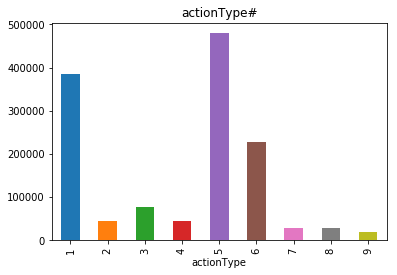

In [5]:
% matplotlib inline

df_action_train.groupby('actionType').count()['userid'].plot(kind='bar',title="actionType#")

In [6]:

%time user_1st_action_time = df_action_train.groupby(['userid']).pipe(lambda u: u.actionTime.min())

Wall time: 150 ms


In [7]:
# 计算间隔时间
df_action_train  = df_action_train.merge(user_1st_action_time.reset_index().rename({'actionTime':'1stActionTime'},axis=1))
%time df_action_train['since1stActionDays']=(df_action_train.actionTime-df_action_train['1stActionTime']).apply(lambda row: row.days)

Wall time: 18.4 s


In [8]:
# 计算session 是否相同,上下文时间<30mins
def cal_session(grp):
    tds = grp.actionTime-grp.actionTime.shift()
    isame =  True if pd.isnull(tds) else tds.components.hours*60+tds.components.minutes<30
    return isame

on_same_session =df_action_train.groupby('userid').apply(lambda grp:grp.actionTime-grp.actionTime.shift())

on_same_session=on_same_session.apply(lambda tds: False if pd.isnull(tds) else tds.components.hours*60+tds.components.minutes<30)



In [9]:
sessions = []
pre = None
for row in on_same_session.iteritems():  
    if not row[1]:
        sessionid= row[0][1]
    sessions.append(sessionid)
    pre = row
df_action_train['sessionid'] = sessions
df_action_train.head(50)

,userid,actionType,actionTime,1stActionTime,since1stActionDays,sessionid
0,100000000013,1,2016-09-19 23:59:13,2016-09-19 23:59:13,0,0
1,100000000013,5,2016-09-19 23:59:23,2016-09-19 23:59:13,0,0
2,100000000013,6,2016-09-20 00:01:14,2016-09-19 23:59:13,0,0
3,100000000013,5,2016-09-20 00:01:51,2016-09-19 23:59:13,0,0
4,100000000013,6,2016-09-20 00:02:16,2016-09-19 23:59:13,0,0
5,100000000013,6,2016-09-20 00:02:21,2016-09-19 23:59:13,0,0
6,100000000013,8,2016-09-20 00:02:52,2016-09-19 23:59:13,0,0
7,100000000013,9,2016-09-20 00:03:10,2016-09-19 23:59:13,0,0
8,100000000013,8,2016-09-20 00:22:56,2016-09-19 23:59:13,0,0
9,100000000013,9,2016-09-20 00:23:14,2016-09-19 23:59:13,0,0


In [10]:
df_action_train.to_csv('../data/interim/df_action_train.csv')

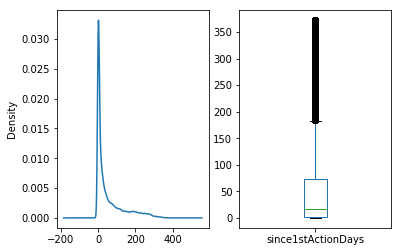

In [11]:
%matplotlib inline
df_user_action_span = df_action_train['since1stActionDays']
# 平均时间(天数)
plt.subplot(1,2,1)

df_user_action_span.plot(kind='kde')
plt.subplot(1,2,2)
df_user_action_span.plot(kind='box')

In [12]:
df_action_train['hour'] = pd.DatetimeIndex(df_action_train['actionTime']).hour

df_action_train['weekday']= pd.DatetimeIndex(df_action_train['actionTime']).weekday+1


In [13]:
df_holiday = pd.read_csv("https://raw.githubusercontent.com/rainx/cn_stock_holidays/master/cn_stock_holidays/data.txt", names=['holiday'])

In [14]:
dt_str=pd.DatetimeIndex(df_action_train.actionTime).strftime('%Y%m%d')
# %time list(curried.map(lambda dt: dt.strftime("%Y%m%d"),a))
# 10s

In [15]:
df_action_train['is_holiday']= np.in1d(dt_str,df_holiday.iloc[:,0].values.ravel())
df_action_train['is_weekend']= df_action_train['weekday'].isin([6,7])

In [16]:
df_action_train.to_csv('../data/interim/df_action_train.csv')
df_action_train.head()

,userid,actionType,actionTime,1stActionTime,since1stActionDays,sessionid,hour,weekday,is_holiday,is_weekend
0,100000000013,1,2016-09-19 23:59:13,2016-09-19 23:59:13,0,0,23,1,False,False
1,100000000013,5,2016-09-19 23:59:23,2016-09-19 23:59:13,0,0,23,1,False,False
2,100000000013,6,2016-09-20 00:01:14,2016-09-19 23:59:13,0,0,0,2,False,False
3,100000000013,5,2016-09-20 00:01:51,2016-09-19 23:59:13,0,0,0,2,False,False
4,100000000013,6,2016-09-20 00:02:16,2016-09-19 23:59:13,0,0,0,2,False,False


In [4]:
df_action_train=pd.read_csv('../data/interim/df_action_train.csv')

### order

In [5]:
df_order = pd.read_csv('../data/raw/trainingset/orderHistory_train.csv')
## 总行数
print("总行数:%d" % df_order.shape[0])
## 查看缺失值
np.sum(df_order.isnull())

总行数:20653


userid       0
orderid      0
orderTime    0
orderType    0
city         0
country      0
continent    0
dtype: int64

In [6]:
df_order.head()

,userid,orderid,orderTime,orderType,city,country,continent
0,100000000013,1000015,1481714516,0,柏林,德国,欧洲
1,100000000013,1000014,1501959643,0,旧金山,美国,北美洲
2,100000000393,1000033,1499440296,0,巴黎,法国,欧洲
3,100000000459,1000036,1480601668,0,纽约,美国,北美洲
4,100000000459,1000034,1479146723,0,巴厘岛,印度尼西亚,亚洲


(1, 10)

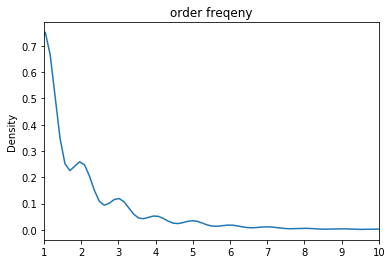

In [8]:
%matplotlib inline
df_order.userid.value_counts().plot(kind='kde',title='order freqeny')
plt.xlim([1,10])

In [9]:
df_order['orderTime'] =df_order['orderTime'].apply(timestamp_datetime)

In [10]:
pd.qcut(df_order['orderTime'],[0,.25,.5,.75,1]).value_counts()

(2016-11-06 00:37:52.999999999, 2017-03-24 19:35:57]    5164
(2017-06-20 19:44:38, 2017-09-11 21:35:53]              5163
(2017-05-11 11:45:54, 2017-06-20 19:44:38]              5163
(2017-03-24 19:35:57, 2017-05-11 11:45:54]              5163
Name: orderTime, dtype: int64

### comment

In [11]:
df_comment = pd.read_csv('../data/raw/trainingset/userComment_train.csv')
## 总行数
print("总行数:%d" % df_comment.shape[0])
## 查看缺失值
np.sum(df_comment.isnull())

总行数:9863


userid                 0
orderid                0
rating                 0
tags                3109
commentsKeyWords    5771
dtype: int64

In [12]:
df_comment.head()

,userid,orderid,rating,tags,commentsKeyWords
0,100000000013,1000015,4.0,NaN,"['很','简陋','太','随便']"
1,100000000231,1000024,5.0,提前联系|耐心等候,"['很','细心']"
2,100000000471,1000038,5.0,NaN,NaN
3,100000000637,1000040,5.0,主动热情|提前联系|举牌迎接|主动搬运行李,NaN
4,100000000755,1000045,1.0,未举牌服务,NaN


###  

In [13]:
from cytoolz import curried
# curried.pipe(curried.map(df_comment.tags.str.split('|',expand=True).values)
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
tags = df_comment.tags.replace(np.nan,'').values
vec = CountVectorizer()
data = vec.fit_transform(tags).toarray()
vec.vocabulary_

{'不协助搬运行李': 0,
 '不懂普通话': 1,
 '不爱讲话': 2,
 '临时换司导': 3,
 '主动搬运行李': 4,
 '主动热情': 5,
 '举牌迎接': 6,
 '仪表整洁': 7,
 '司导态度差': 8,
 '干净整洁': 9,
 '建筑师': 10,
 '接待地点不合理': 11,
 '提前就终止了服务': 12,
 '提前结束行程': 13,
 '提前联系': 14,
 '文明礼貌': 15,
 '普通话流利': 16,
 '景点不介绍': 17,
 '景点不熟悉': 18,
 '景点介绍详尽': 19,
 '未举牌服务': 20,
 '未提前联系': 21,
 '沉默寡言': 22,
 '没做景点介绍': 23,
 '没有放水': 24,
 '没水': 25,
 '留学生': 26,
 '私聊不回复': 27,
 '空调不足': 28,
 '耐心等候': 29,
 '行前未主动联系': 30,
 '行前联系不上': 31,
 '行程安排不合理': 32,
 '行程安排有惊喜': 33,
 '行程有点紧': 34,
 '言语粗鲁': 35,
 '路线不熟': 36,
 '路线熟悉': 37,
 '车内有异味': 38,
 '车况有点旧': 39,
 '车况脏乱': 40,
 '车旧': 41,
 '车辆和订单显示不符': 42,
 '车辆物资齐全': 43,
 '非订单车辆': 44,
 '频繁催促': 45,
 '额外收费': 46,
 '驾驶平稳': 47,
 '驾驶鲁莽': 48}

In [14]:
tfidf4 =TfidfTransformer().fit_transform(data)
print(tfidf4[-5:] )

  (0, 29)	0.384075777548
  (0, 14)	0.360542900745
  (0, 6)	0.76388829866
  (0, 5)	0.372785837973
  (2, 47)	0.359027691384
  (2, 43)	0.376472006034
  (2, 29)	0.24435262715
  (2, 16)	0.359402177633
  (2, 15)	0.405250440514
  (2, 14)	0.22938078928
  (2, 9)	0.407827403678
  (2, 5)	0.237169861256
  (2, 4)	0.317920766077
  (3, 43)	0.513122838305
  (3, 16)	0.489857047866
  (3, 9)	0.555859536857
  (3, 4)	0.433318821137


### orderFuture_train

In [15]:
df_orderFuture = pd.read_csv('../data/raw/trainingset/orderFuture_train.csv')
## 总行数
print("总行数:%d" % df_order.shape[0])
## 查看缺失值
np.sum(df_orderFuture.isnull())

总行数:20653


userid       0
orderType    0
dtype: int64

In [16]:
df_orderFuture.tail(20)

,userid,orderType
40287,114869669649,0
40288,114869767141,0
40289,114869767649,0
40290,114869769143,0
40291,114869867143,1
40292,114869867443,1
40293,114869867749,0
40294,114869967142,0
40295,114869967540,0
40296,114869967746,0


In [17]:
df_order.loc[df_order.userid==114999280232]

,userid,orderid,orderTime,orderType,city,country,continent
20650,114999280232,1104664,2017-04-02 02:47:34,0,迈阿密,美国,北美洲
20651,114999280232,1104665,2017-04-24 23:33:03,0,东京,日本,亚洲
20652,114999280232,1104667,2017-05-02 21:41:38,1,东京,日本,亚洲


In [18]:
"""
上次购买后，评价好，并且后续仍有浏览行为
"""
print(__doc__)
df_action_train.loc[df_action_train.userid==114999280232]


上次购买后，评价好，并且后续仍有浏览行为



,Unnamed: 0,userid,actionType,actionTime,1stActionTime,since1stActionDays,sessionid,hour,weekday,is_holiday,is_weekend
1334745,1334745,114999280232,1,2017-03-21 21:26:04,2017-03-21 21:26:04,0,1334745,21,2,False,False
1334746,1334746,114999280232,5,2017-03-21 21:26:12,2017-03-21 21:26:04,0,1334745,21,2,False,False
1334747,1334747,114999280232,6,2017-03-21 21:26:39,2017-03-21 21:26:04,0,1334745,21,2,False,False
1334748,1334748,114999280232,1,2017-04-02 02:44:04,2017-03-21 21:26:04,11,1334748,2,7,False,True
1334749,1334749,114999280232,5,2017-04-02 02:44:14,2017-03-21 21:26:04,11,1334748,2,7,False,True
1334750,1334750,114999280232,5,2017-04-02 02:44:50,2017-03-21 21:26:04,11,1334748,2,7,False,True
1334751,1334751,114999280232,6,2017-04-02 02:47:04,2017-03-21 21:26:04,11,1334748,2,7,False,True
1334752,1334752,114999280232,8,2017-04-02 02:47:37,2017-03-21 21:26:04,11,1334748,2,7,False,True
1334753,1334753,114999280232,1,2017-04-24 23:30:41,2017-03-21 21:26:04,34,1334753,23,1,False,False
1334754,1334754,114999280232,5,2017-04-24 23:30:50,2017-03-21 21:26:04,34,1334753,23,1,False,False


## 计算会员活跃度

1.根据user action 统计用户活跃度

| 用户行为 	| actionType 数值 	| 行为类型 	| 权重 	|
|----------	|-----------------	|----------	|------	|
| 唤醒app  	| 1               	| 登录     	| 1    	|
| 浏览产品 	| 2－4            	| 互动行为 	| 1    	|
| 填写表单 	| 5               	| 订单行为 	| 1    	|
| 提交订单 	| 6               	| 订单行为 	| 1    	|
| ……       	| 7               	| 订单行为 	| 1    	|
| ……       	| 8               	| 订单行为 	| 1    	|
| 支付     	| 9               	| 订单行为 	| 1    	|

2.根据 user comment评论的评分分群

| 评论得分      	| rating数值 	| 权重 	|
|---------------	|------------	|------	|
| 好评          	| >3         	| 1    	|
| 中评          	| 3          	| 0    	|
| 差评          	| <3         	| -1   	|
| 好评+评论内容 	| >3         	| 2    	|
| 差评+评论内容 	| <3         	| -2   	|

In [110]:
df_action_stat= pd.concat([df_action_train[['userid','sessionid']] , pd.get_dummies(df_action_train['actionType'])], axis=1)
df_action_stat=(df_action_stat.groupby(['userid','sessionid']).sum()>0)
df_action_stat.columns = ['a'+str(c) for c in df_action_stat.columns]

In [117]:
df_action_stat.head()

1      2      3      4      5      6      7      8  \
userid       sessionid                                                          
100000000013 0          True  False  False  False   True   True  False   True   
             10         True  False  False  False   True  False  False  False   
             13         True  False  False  False  False  False  False  False   
             14         True  False  False  False  False  False  False  False   
             15         True  False  False  False   True  False  False  False   

                            9  
userid       sessionid         
100000000013 0           True  
             10         False  
             13         False  
             14         False  
             15         False

In [140]:
df_action_train[df_action_train.sessionid<152].tail(30)

,Unnamed: 0,userid,actionType,actionTime,1stActionTime,since1stActionDays,sessionid,hour,weekday,is_holiday,is_weekend,activityRating
122,122,100000000013,3,2017-08-06 07:33:30,2016-09-19 23:59:13,320,122,7,7,False,True,0
123,123,100000000013,1,2017-08-06 07:45:19,2016-09-19 23:59:13,320,122,7,7,False,True,1
124,124,100000000013,1,2017-08-06 08:15:13,2016-09-19 23:59:13,320,122,8,7,False,True,1
125,125,100000000013,3,2017-08-06 08:15:23,2016-09-19 23:59:13,320,122,8,7,False,True,0
126,126,100000000013,1,2017-08-06 18:25:56,2016-09-19 23:59:13,320,126,18,7,False,True,1
127,127,100000000013,1,2017-08-06 21:32:02,2016-09-19 23:59:13,320,127,21,7,False,True,1
128,128,100000000013,5,2017-08-06 21:42:59,2016-09-19 23:59:13,320,127,21,7,False,True,1
129,129,100000000013,1,2017-08-07 12:08:49,2016-09-19 23:59:13,321,129,12,1,False,False,1
130,130,100000000013,3,2017-08-07 13:15:52,2016-09-19 23:59:13,321,130,13,1,False,False,0
131,131,100000000013,1,2017-08-07 14:53:01,2016-09-19 23:59:13,321,131,14,1,False,False,1


In [121]:
from mlxtend.frequent_patterns import apriori

apriori(df_action_stat,0.05, use_colnames= True)

,support,itemsets
0,0.868322,[1]
1,0.064440,[2]
2,0.061774,[3]
3,0.549988,[5]
4,0.324214,[6]
5,0.064102,[7]
6,0.053906,[8]
7,0.054236,"[1, 2]"
8,0.444482,"[1, 5]"
9,0.262023,"[1, 6]"


In [101]:
# 5－9行为连续出现的频率
# def action_dict()
df_action_train.loc[:100,['userid','sessionid','actionType']].groupby(['userid','sessionid']).sum()

actionType
userid       sessionid            
100000000013 0                  63
             10                  7
             13                  1
             14                  1
             15                  6
             17                 19
             20                  1
             21                  1
             22                 22
             28                  6
             29                 17
             33                  6
             34                 38
             41                  1
             42                  1
             43                  1
             44                  1
             45                  1
             46                  1
             47                 22
             52                  1
             53                  1
             54                  1
             55                  1
             56                  1
             57                  1
             58                  6
             60                  1
             61                  6
             63                  1
             64                  1
             65                  1
             66                 16
             69                  6
             70                  6
             71                  1
             72                  5
             73                  1
             74                 12
             77                  1
             78                  1
             79                  1
             80                  1
             81                  2
             83                  1
             84                  2
             86                  1
             87                  5
             88                  1
             89                  1
             90                  1
             91                  5
             92                  1
             93                  1
             94                  1
             95                  1
             96                  6
             98                  1
             99                  1
             100                 1

In [ ]:
df_action_train[['userid','sessionid','actionType']].groupby(['userid','sessionid']).apply

In [34]:
df_user_train = df_userprofile_train.copy()

In [54]:
actionType_weight = dict(zip(list(range(1,10)),[1]*9))
actionType_weight[2]=0; actionType_weight[3]=0; actionType_weight[4]=0; 
df_action_train['activityRating'] = df_action_train['actionType'].map(actionType_weight)
df_actitity = df_action_train[['userid','activityRating']].groupby('userid').sum()

In [77]:
pd.qcut(df_actitity['activityRating'],4,retbins =True)
df_actitity[df_actitity['activityRating'] >= df_actitity['activityRating'].quantile(.999)]
df_action_train[df_action_train.userid ==100000000423].tail(20)

,Unnamed: 0,userid,actionType,actionTime,1stActionTime,since1stActionDays,sessionid,hour,weekday,is_holiday,is_weekend,activityRating
968,968,100000000423,1,2017-09-09 04:00:43,2016-12-14 04:08:49,268,932,4,6,False,True,1
969,969,100000000423,1,2017-09-09 04:05:09,2016-12-14 04:08:49,268,932,4,6,False,True,1
970,970,100000000423,1,2017-09-09 23:44:33,2016-12-14 04:08:49,269,970,23,6,False,True,1
971,971,100000000423,1,2017-09-09 23:49:56,2016-12-14 04:08:49,269,970,23,6,False,True,1
972,972,100000000423,1,2017-09-10 00:06:18,2016-12-14 04:08:49,269,970,0,7,False,True,1
973,973,100000000423,1,2017-09-10 00:11:40,2016-12-14 04:08:49,269,970,0,7,False,True,1
974,974,100000000423,1,2017-09-10 00:16:49,2016-12-14 04:08:49,269,970,0,7,False,True,1
975,975,100000000423,1,2017-09-10 00:20:05,2016-12-14 04:08:49,269,970,0,7,False,True,1
976,976,100000000423,1,2017-09-10 00:35:20,2016-12-14 04:08:49,269,970,0,7,False,True,1
977,977,100000000423,5,2017-09-10 00:36:01,2016-12-14 04:08:49,269,970,0,7,False,True,1


In [78]:
df_orderFuture[df_orderFuture.userid==100000000423]

,userid,orderType
6,100000000423,0


##  会员价值 ( RFM 模型）
分群，复购率，消费频次，最近购买时间